# **Predicting Surname Origins using Recurrent Neural Networks (RNN)**

In this Jupyter Notebook, we will explore the implementation of a machine learning model designed to predict the language origin of surnames. The model is built using PyTorch and employs a Recurrent Neural Network (RNN) to classify surnames into their corresponding languages based on a trained dataset of international surnames.

***

## **1. Preparing the Data**

First we load and preprocess the data from text files containing surnames from different languages, normalize Unicode characters to a standard ASCII format, and finally organize these surnames into a single dictionary categorized by the various languages.

In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['../data/names/Czech.txt', '../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Japanese.txt', '../data/names/Chinese.txt', '../data/names/Vietnamese.txt', '../data/names/Russian.txt', '../data/names/French.txt', '../data/names/Irish.txt', '../data/names/English.txt', '../data/names/Spanish.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Dutch.txt', '../data/names/Korean.txt', '../data/names/Polish.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


***

## **2. Turning Names into Tensors**

We define and implement functions in order to convert individual letters into one-hot encoded characters and individual surnames into tensors of those encoded characters, these will be the inputs to our model of the neural network.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


***

## **3. Creating the Network**

We define a Recurrent Neural Network (RNN) class using the Neural Network (NN) module from PyTorch. This is done to allow the model the ability to process an input of encoded characters through layers in order to update the hidden states, the result is an ouput representing a prediction for the language origin of the surnames.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9392, -2.8890, -2.9677, -2.8472, -2.8085, -2.8770, -2.8222, -2.8824,
         -2.9477, -2.7876, -2.9986, -3.0001, -2.9896, -2.7900, -2.9425, -2.8966,
         -2.8217, -2.8627]], grad_fn=<LogSoftmaxBackward0>)


***

## **4. Preparing for Training**

We define some necessary components for training the model such as the loss function and a training loop that iterates through each character in a surname, computes the loss, use backpropagation to update the network's weights, and adjusts the model parameters using a defined learning rate.

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 9)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Allan
category = Portuguese / line = Santos
category = Vietnamese / line = Quyen
category = Greek / line = Close
category = Vietnamese / line = Vuong
category = Italian / line = Vescovi
category = Russian / line = Avrus
category = Dutch / line = Oorschot
category = Dutch / line = Veen
category = Scottish / line = Munro


***

## **5. Training the Network**

We train the network over many iterations using randomly selected examples taken from the dataset. We also keep track of and visualize the training loss in order to better monitor performance and progress.

In [9]:
criterion = nn.NLLLoss()

In [10]:
learning_rate = 0.005   # If set too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.5715 Steere / French ✗ (English)
10000 10% (0m 20s) 1.5857 Takahashi / Polish ✗ (Japanese)
15000 15% (0m 29s) 0.8100 Yeo / Korean ✓
20000 20% (0m 38s) 0.2943 Luong / Vietnamese ✓
25000 25% (0m 48s) 3.5178 Mata / Japanese ✗ (Portuguese)
30000 30% (0m 57s) 0.3529 AbdankKossovsky / Russian ✓
35000 35% (1m 6s) 2.1588 Sleiman / Czech ✗ (Arabic)
40000 40% (1m 16s) 1.9716 Dahl / Vietnamese ✗ (German)
45000 45% (1m 25s) 1.7431 Moller / English ✗ (German)
50000 50% (1m 36s) 3.2810 Tzeizik / Czech ✗ (Russian)
55000 55% (1m 46s) 0.0605 Egonidis / Greek ✓
60000 60% (1m 56s) 3.5689 Brand / Scottish ✗ (German)
65000 65% (2m 6s) 2.4581 Raskoph / English ✗ (German)
70000 70% (2m 15s) 0.4244 Cernochova / Czech ✓
75000 75% (2m 25s) 0.0936 Sauvageot / French ✓
80000 80% (2m 35s) 0.8737 Schermer / German ✗ (Dutch)
85000 85% (2m 45s) 3.0540 Lyon / English ✗ (French)
90000 90% (2m 55s) 0.2307 Fitzgerald / English ✓
95000 95% (3m 6s) 2.5618 Renwick / Czech ✗ (English)
100000 100% (3m 16s) 0

***

## **6. Plotting the Results**

We use matplotlib in order to plot the training loss over time, as well as implement a confusion matrix heatmap for us to better understand the model's accuracy and performance across different categories through visualization. To ouput probabilities, we normalize the matrix.

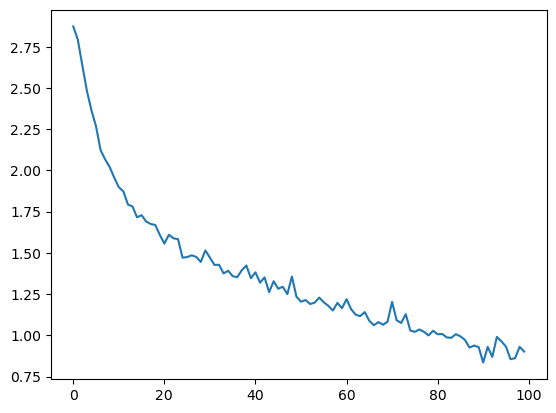

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/zp/_d_rstf11flfs_c9y4mt102w0000gn/T/ipykernel_11347/2541528099.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/zp/_d_rstf11flfs_c9y4mt102w0000gn/T/ipykernel_11347/2541528099.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


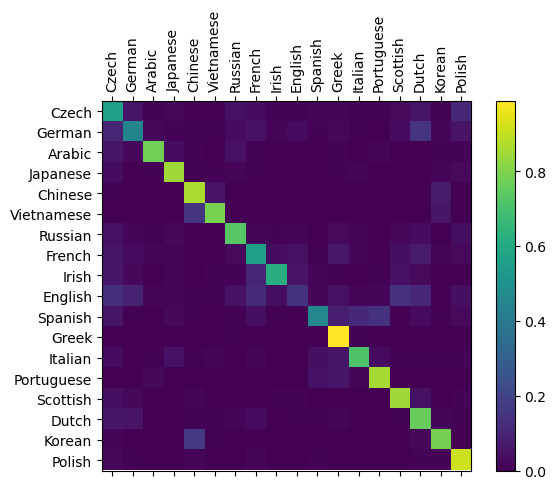

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

***

## **7. Running on User Input**

Lastly we complete the model by implementing a function that allows it to predict the language origin of new input surnames based on the training data, the function then evaluates the model's given output and displays the top predicted language.

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.75) Russian
(-0.76) Czech
(-3.55) English

> Jackson
(-0.03) Scottish
(-4.71) Polish
(-4.76) English

> Satoshi
(-0.08) Japanese
(-3.20) Polish
(-3.52) Italian


In [16]:
predict('Cortez')


> Cortez
(-0.24) Spanish
(-3.01) Dutch
(-3.21) German


The model correctly predicted the language of my surname. But there is always room for improvement, and there are a few methods we can implement in order to improve the model's overall accuracy such as expanding the training dataset, implementing regularization techniques, or even using different models like Long Short-Term Memory (LSTM).